# Detecting patterns of speciation in the fossil record 

In this project, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space, curated in Helsinki since 1993. In particular, we are interested to know when and where speciation rates have been significantly high. The aim is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. 

### Data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

URL = 'http://www.helsinki.fi/science/now/'

# Load the datset form the above URL (in txt) and convert it to csv
df = pd.read_csv('dataset.txt', sep = ',', na_values='\\N', low_memory = False)
df.to_csv('dataset.csv', index = None)

# Copy the dataset so that we don't mess with the original one
df = df.copy()

### Data cleaning and preprocessing

In [2]:
df.head() 

,LIDNUM,NAME,LATSTR,LONGSTR,LAT,LONG,ALTITUDE,MAX_AGE,BFA_MAX,BFA_MAX_ABS,...,STONE_TOOLS,TECHNOLOGICAL_MODE_1,TECHNOLOGICAL_MODE_2,TECHNOLOGICAL_MODE_3,CULTURAL_STAGE_1,CULTURAL_STAGE_2,CULTURAL_STAGE_3,REGIONAL_CULTURE_1,REGIONAL_CULTURE_2,REGIONAL_CULTURE_3
0,21390,Aarau,47 23 0 N,8 3 0 E,47.383000,8.050000,NaN,14.2000,mn6,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29029,Aarwangen,47 14 37 N,7 45 21 E,47.243654,7.755959,NaN,25.4100,mp27,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27232,Aba Zawei,33 15 00 N,102 25 00 E,33.250000,102.416667,NaN,0.0295,NaN,C14,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27232,Aba Zawei,33 15 00 N,102 25 00 E,33.250000,102.416667,NaN,0.0295,NaN,C14,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27232,Aba Zawei,33 15 00 N,102 25 00 E,33.250000,102.416667,NaN,0.0295,NaN,C14,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(84433, 102)

The dataset has 84433 rows and 102 columns as seen from above. In the DataFrame, each row represents one fossil occurrence. The columns LONG and LAT give the longitude and latitude, respectively, of where a given fossil occurrence was found. The columns MIN AGE and MAX AGE give an estimation of the age of the fossil (in millions of years). The column LIDNUM contains a unique
identification number for each locality, where fossils have been found. The columns GENUS and SPECIES give information on the
taxonomic identification of the fossil. From the cell below we also see that the the other columns have a lot of null values.

In [4]:
df.isnull().sum()

LIDNUM                    0
NAME                      0
LATSTR                    0
LONGSTR                   0
LAT                       0
                      ...  
CULTURAL_STAGE_2      84433
CULTURAL_STAGE_3      84433
REGIONAL_CULTURE_1    83903
REGIONAL_CULTURE_2    84387
REGIONAL_CULTURE_3    84433
Length: 102, dtype: int64

All rows where LAT = LONG = 0 have incorrect coordinates. We drop rows where SPECIES is “sp.” or
“indet.” as these occurrences have not been properly identified.

In [5]:
# In this case we don't need to store these dataset at all, so we may just ovverride it
df = df[~((df['LAT'] == 0) & (df['LONG'] == 0))]
df = df[~df['SPECIES'].isin(['sp.', 'indet.'])]

df.shape

(62476, 102)

For now we may only consider the following rows:

In [6]:
df_reduced = df[['LIDNUM', 'NAME','LONG', 'LAT', 'MIN_AGE', 'MAX_AGE', 'GENUS', 'SPECIES']]
df_reduced.head()

,LIDNUM,NAME,LONG,LAT,MIN_AGE,MAX_AGE,GENUS,SPECIES
0,21390,Aarau,8.050000,47.383000,12.8500,14.2000,Microtherium,renggeri
1,29029,Aarwangen,7.755959,47.243654,24.5600,25.4100,Bachitherium,insigne
3,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Coelodonta,antiquitatis
4,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Bos,primigenius
5,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Gazella,prjewalskyi


In [7]:
df.shape # Obviously we have as many rows as before but rest of the columns are removed for now

(62476, 102)

Next we will assign each occurrence to a specific Mammal Neogene
(MN) time unit. Table 1 shows the time boundaries of each time unit.
Then we assign each occurrence to a correct time unit by calculating the mean of
MIN AGE and MAX AGE. If the mean age of an occurrence is precisely
on the boundary between two time units, the occurrence is assingned to the
older time unit. If the mean age of an occurrence is outside of the MN
time interval, we assign it to a “pre-MN” or “post-MN” category.

Table 1. MN time unit boundaries (in millions of years ago). Note that MN7
and MN8 are combined into one time unit. This is a decision that scientists
have made because of complications in separating the two units at popular
fossil localities. The table isn't displayed here for visual reasons.

We will create a list corresponding to this table in python, then assign the mn values to each occurrence based on there average age. In the list each element is a row from the Table 1 above where each tuple is in (name, max, min) format.

In [8]:
mn_boundaries = [
    ("MN1", 23, 21.7),
    ("MN2", 21.7, 19.5),
    ("MN3", 19.5, 17.2),
    ("MN4", 17.2, 16.4),
    ("MN5", 16.4, 14.2),
    ("MN6", 14.2, 12.85),
    ("MN7-8", 12.85, 11.2),
    ("MN9", 11.2, 9.9),
    ("MN10", 9.9, 8.9),
    ("MN11", 8.9, 7.6),
    ("MN12", 7.6, 7.1),
    ("MN13", 7.1, 5.3),
    ("MN14", 5.3, 5),
    ("MN15", 5, 3.55),
    ("MN16", 3.55, 2.5),
    ("MN17", 2.5, 1.9),
    ("MQ18", 1.9, 0.85),
    ("MQ19", 0.85, 0.01),
]

In [9]:
# Then create a function that gives the correponding unit based on the provided min and max age:
def assign_mn(min_age, max_age):
    mean_age = (min_age + max_age) / 2

    if mean_age > 23:
        return "Pre-MN"
    elif mean_age < 0.01:
        return "Post-MN"

    for unit, max_bound, min_bound in mn_boundaries:
        if min_bound <= mean_age < max_bound:
            return unit

In [10]:
df_reduced[df_reduced['NAME'] == "Samos Main Bone Beds"]

,LIDNUM,NAME,LONG,LAT,MIN_AGE,MAX_AGE,GENUS,SPECIES
66002,20484,Samos Main Bone Beds,26.877,37.507,7.14,7.528,Plioviverrops,orbignyi
66003,20484,Samos Main Bone Beds,26.877,37.507,7.14,7.528,Ictitherium,viverrinum
66004,20484,Samos Main Bone Beds,26.877,37.507,7.14,7.528,Lycyaena,chaeretis
66005,20484,Samos Main Bone Beds,26.877,37.507,7.14,7.528,Adcrocuta,eximia
66006,20484,Samos Main Bone Beds,26.877,37.507,7.14,7.528,Indarctos,atticus
66007,20484,Samos Main Bone Beds,26.877,37.507,7.14,7.528,Parataxidea,maraghana
66008,20484,Samos Main Bone Beds,26.877,37.507,7.14,7.528,Promephitis,lartetii
66009,20484,Samos Main Bone Beds,26.877,37.507,7.14,7.528,Promeles,palaeatticus
66010,20484,Samos Main Bone Beds,26.877,37.507,7.14,7.528,Amphimachairodus,giganteus
66011,20484,Samos Main Bone Beds,26.877,37.507,7.14,7.528,Metailurus,parvulus


In [59]:
df_reduced.loc[:, 'MN TIME UNIT'] = df_reduced.apply(lambda row: assign_mn(row['MIN_AGE'], row['MAX_AGE']), axis=1)
df_reduced.head()

,LIDNUM,NAME,LONG,LAT,MIN_AGE,MAX_AGE,GENUS,SPECIES,MN TIME UNIT,GENUS_SPECIES,Species_ID
0,21390,Aarau,8.050000,47.383000,12.8500,14.2000,Microtherium,renggeri,MN6,Microtherium renggeri,0
1,29029,Aarwangen,7.755959,47.243654,24.5600,25.4100,Bachitherium,insigne,Pre-MN,Bachitherium insigne,1
3,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Coelodonta,antiquitatis,MQ19,Coelodonta antiquitatis,2
4,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Bos,primigenius,MQ19,Bos primigenius,3
5,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Gazella,prjewalskyi,MQ19,Gazella prjewalskyi,4


We are told that there are some exceptions in our data. In our case, experts in palaeontology
tell us that occurrences in the localities “Samos Main Bone Beds” and
“Can Llobateres I” should be assigned to time units MN12 and MN9,
respectively. So, we check these and if necessary, edit the time units to their
correct values.


In [12]:
# This seems to be all correctly assigned, however we will assign it to the correct values nevertheless
df_reduced[df_reduced['NAME'] == "Samos Main Bone Beds"]
df_reduced.loc[df_reduced['NAME'] == 'Samos Main Bone Beds', 'MN TIME UNIT'] = 'MN12'

In [13]:
df_reduced[df_reduced['NAME'] == "Can Llobateres I"]

,LIDNUM,NAME,LONG,LAT,MIN_AGE,MAX_AGE,GENUS,SPECIES,MN TIME UNIT


In [14]:
# There seems to be no case of locality with the Can Llovateres I, however we will double check this just to be sure
df_reduced[df_reduced['NAME'].str.startswith('Can Llobateres')]

,LIDNUM,NAME,LONG,LAT,MIN_AGE,MAX_AGE,GENUS,SPECIES,MN TIME UNIT
9018,20020,Can Llobateres 1,2.136910,41.532663,9.7210,9.786,Albanosmilus,jourdani,MN10
9019,20020,Can Llobateres 1,2.136910,41.532663,9.7210,9.786,Trocharion,albanense,MN10
9020,20020,Can Llobateres 1,2.136910,41.532663,9.7210,9.786,Protictitherium,crassum,MN10
9021,20020,Can Llobateres 1,2.136910,41.532663,9.7210,9.786,Ursavus,brevirhinus,MN10
9023,20020,Can Llobateres 1,2.136910,41.532663,9.7210,9.786,Machairodus,aphanistus,MN10
...,...,...,...,...,...,...,...,...,...
9102,28251,Can Llobateres 2,2.137497,41.533568,9.5365,9.647,Cricetulodon,sabadellensis,MN10
9103,28251,Can Llobateres 2,2.137497,41.533568,9.5365,9.647,Progonomys,hispanicus,MN10
9104,28251,Can Llobateres 2,2.137497,41.533568,9.5365,9.647,Heteroxerus,grivensis,MN10
9105,28251,Can Llobateres 2,2.137497,41.533568,9.5365,9.647,Tetralophodon,longirostris,MN10


In [15]:
# Looks like it is the number "1" instead of Roman numeral "I", furthermore we see that 
# they are assigned to MN time unit MN10, so we will change that
df_reduced.loc[df_reduced['NAME'] == 'Can Llobateres 1', 'MN TIME UNIT'] = 'MN9'
df_reduced[df_reduced['NAME'] == 'Can Llobateres 1']

,LIDNUM,NAME,LONG,LAT,MIN_AGE,MAX_AGE,GENUS,SPECIES,MN TIME UNIT
9018,20020,Can Llobateres 1,2.13691,41.532663,9.721,9.786,Albanosmilus,jourdani,MN9
9019,20020,Can Llobateres 1,2.13691,41.532663,9.721,9.786,Trocharion,albanense,MN9
9020,20020,Can Llobateres 1,2.13691,41.532663,9.721,9.786,Protictitherium,crassum,MN9
9021,20020,Can Llobateres 1,2.13691,41.532663,9.721,9.786,Ursavus,brevirhinus,MN9
9023,20020,Can Llobateres 1,2.13691,41.532663,9.721,9.786,Machairodus,aphanistus,MN9
...,...,...,...,...,...,...,...,...,...
9086,20020,Can Llobateres 1,2.13691,41.532663,9.721,9.786,Megacricetodon,minutus,MN9
9089,20020,Can Llobateres 1,2.13691,41.532663,9.721,9.786,Dinosorex,grycivensis,MN9
9091,20020,Can Llobateres 1,2.13691,41.532663,9.721,9.786,Bransatoglis,astaracensis,MN9
9092,20020,Can Llobateres 1,2.13691,41.532663,9.721,9.786,Listriodon,splendens,MN9


We need to be able to identify all occurrences of each species. We assign
a unique identification number for each unique combination of GENUS
and SPECIES. Then we create a new column in the DataFrame and label each
occurrence with a corresponding species identification number.

In [58]:
# For this we first combine the unique combination of GENUS and SPECIES into the same column called GENUS SPECIES
df_reduced.loc[:, 'GENUS_SPECIES'] = df_reduced['GENUS'] + ' ' + df_reduced['SPECIES']
df_reduced.loc[:, 'Species_ID'] = pd.factorize(df_reduced['GENUS_SPECIES'])[0]

df_reduced.head()

,LIDNUM,NAME,LONG,LAT,MIN_AGE,MAX_AGE,GENUS,SPECIES,MN TIME UNIT,GENUS_SPECIES,Species_ID
0,21390,Aarau,8.050000,47.383000,12.8500,14.2000,Microtherium,renggeri,MN6,Microtherium renggeri,0
1,29029,Aarwangen,7.755959,47.243654,24.5600,25.4100,Bachitherium,insigne,Pre-MN,Bachitherium insigne,1
3,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Coelodonta,antiquitatis,MQ19,Coelodonta antiquitatis,2
4,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Bos,primigenius,MQ19,Bos primigenius,3
5,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Gazella,prjewalskyi,MQ19,Gazella prjewalskyi,4


Each locality should contain no more than one occurrence of any species. 
So we drop the rows where there any duplicates. First we check the original
shape of the dataset

In [17]:
df_reduced.shape

(62476, 11)

In [18]:
df_unique = df_reduced.drop_duplicates(subset=['LIDNUM', 'GENUS_SPECIES'], keep='first')
df_unique.shape

(62418, 11)

In [19]:
f'We can see that the total of {62476 - 62418} were duplicates and hence dropped.'

'We can see that the total of 58 were duplicates and hence dropped.'

In [20]:
# The final dataset after preprocessing looks as follows:
df_unique.head()

,LIDNUM,NAME,LONG,LAT,MIN_AGE,MAX_AGE,GENUS,SPECIES,MN TIME UNIT,GENUS_SPECIES,Species_ID
0,21390,Aarau,8.050000,47.383000,12.8500,14.2000,Microtherium,renggeri,MN6,Microtherium renggeri,0
1,29029,Aarwangen,7.755959,47.243654,24.5600,25.4100,Bachitherium,insigne,Pre-MN,Bachitherium insigne,1
3,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Coelodonta,antiquitatis,MQ19,Coelodonta antiquitatis,2
4,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Bos,primigenius,MQ19,Bos primigenius,3
5,27232,Aba Zawei,102.416667,33.250000,0.0235,0.0295,Gazella,prjewalskyi,MQ19,Gazella prjewalskyi,4


### Visualization

Now we will be treating the df_unique as our dataset for visualization purposes

First we will create a DataFrame that shows for each species how many
occurrences it has in each time unit:

In [21]:
occurrences = df_unique.groupby(['GENUS_SPECIES', 'MN TIME UNIT']).size().reset_index(name='Occurrences')
occurrences

,GENUS_SPECIES,MN TIME UNIT,Occurrences
0,Aaptoryctes ivyi,Pre-MN,2
1,Abdahyrax philipi,Pre-MN,1
2,Abderites meridionalis,MN4,1
3,Abderites meridionalis,MN5,1
4,Abdounodus hamdii,Pre-MN,1
...,...,...,...
18087,Zygolophodon turicensis,MN5,21
18088,Zygolophodon turicensis,MN6,14
18089,Zygolophodon turicensis,MN7-8,13
18090,Zygolophodon turicensis,MN9,7


Then,we create a different DataFrame
that shows for each species the time unit when it is first observed (i.e.
the oldest time unit)

In [22]:
first_observation = df_unique.groupby('GENUS_SPECIES')['MN TIME UNIT'].min().reset_index(name='FirstObservedTimeUnit')
first_observation

,GENUS_SPECIES,FirstObservedTimeUnit
0,Aaptoryctes ivyi,Pre-MN
1,Abdahyrax philipi,Pre-MN
2,Abderites meridionalis,MN4
3,Abdounodus hamdii,Pre-MN
4,Abelmoschomys phthanus,MN9
...,...,...
11284,Zygolophodon nemonguensis,MN7-8
11285,Zygolophodon pyrenaicus,MN12
11286,Zygolophodon shansiensis,MN12
11287,Zygolophodon turicensis,MN10


Next for each time unit, we will calculate the proportion of first
occurrences to all occurrence by frist merging the two datasets above 
and then calculating their respective sum by grouping them together.

In [23]:
merged = occurrences.merge(first_observation, on="GENUS_SPECIES")
merged.head()

,GENUS_SPECIES,MN TIME UNIT,Occurrences,FirstObservedTimeUnit
0,Aaptoryctes ivyi,Pre-MN,2,Pre-MN
1,Abdahyrax philipi,Pre-MN,1,Pre-MN
2,Abderites meridionalis,MN4,1,MN4
3,Abderites meridionalis,MN5,1,MN4
4,Abdounodus hamdii,Pre-MN,1,Pre-MN


In [24]:
merged["IsFirstOccurrence"] = merged["MN TIME UNIT"] == merged["FirstObservedTimeUnit"]
merged.head()

,GENUS_SPECIES,MN TIME UNIT,Occurrences,FirstObservedTimeUnit,IsFirstOccurrence
0,Aaptoryctes ivyi,Pre-MN,2,Pre-MN,True
1,Abdahyrax philipi,Pre-MN,1,Pre-MN,True
2,Abderites meridionalis,MN4,1,MN4,True
3,Abderites meridionalis,MN5,1,MN4,False
4,Abdounodus hamdii,Pre-MN,1,Pre-MN,True


In [34]:
time_unit_summary = merged.groupby("MN TIME UNIT").agg(
    TotalOccurrences=("Occurrences", "sum"),
    FirstOccurrences=("IsFirstOccurrence", "sum"),
).reset_index()

time_unit_summary.head()

,MN TIME UNIT,TotalOccurrences,FirstOccurrences
0,MN1,525,228
1,MN10,1675,624
2,MN11,1886,407
3,MN12,2191,253
4,MN13,2759,671


In [51]:
time_unit_summary["ProportionFirstOccurrences"] = (time_unit_summary["FirstOccurrences"] / time_unit_summary["TotalOccurrences"])

# The previous table had the MN time units in random order so we will sort that out for now.
custom_order = [
    "Pre-MN", "MN1", "MN2", "MN3", "MN4", "MN5", "MN6", "MN7-8", 
    "MN9", "MN10", "MN11", "MN12", "Post-MN"
]
time_unit_summary["MN TIME UNIT"] = pd.Categorical(time_unit_summary["MN TIME UNIT"], categories=custom_order, ordered=True)
time_unit_summary = time_unit_summary.sort_values("MN TIME UNIT").reset_index(drop=True)
time_unit_summary


,MN TIME UNIT,TotalOccurrences,FirstOccurrences,ProportionFirstOccurrences
0,Pre-MN,11835,3582,0.302662
1,MN1,525,228,0.434286
2,MN2,1514,463,0.305812
3,MN3,2673,525,0.196409
4,MN4,3048,385,0.126312
5,MN5,4412,454,0.102901
6,MN6,2268,223,0.098325
7,MN7-8,2858,315,0.110217
8,MN9,2065,162,0.078450
9,MN10,1675,624,0.372537


Next we will the proportion of first occurrences
over time.

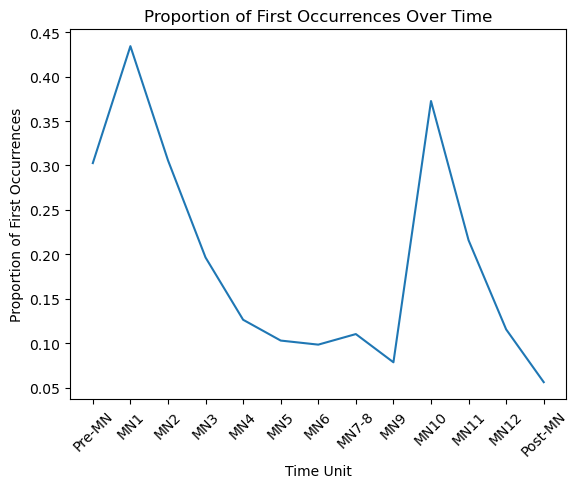

In [55]:
# Lots of NaN values at the end, which we will drop for plotting purposes
# We will also need to convert the values into str as plt wont allow the plotting
# categorical values
time_unit_summary = time_unit_summary.dropna()
time_unit_summary["MN TIME UNIT"] = time_unit_summary["MN TIME UNIT"].astype(str)

plt.plot(time_unit_summary["MN TIME UNIT"], time_unit_summary["ProportionFirstOccurrences"])
plt.xlabel("Time Unit")
plt.ylabel("Proportion of First Occurrences")
plt.title("Proportion of First Occurrences Over Time")
plt.xticks(rotation=45);


And for the total number of occurrences over time.

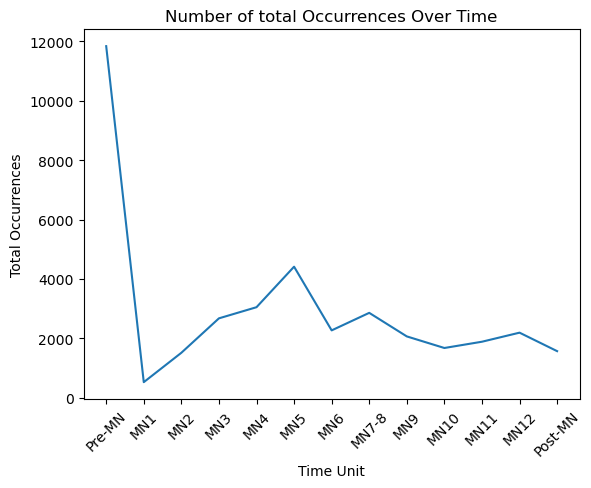

In [57]:
plt.plot(time_unit_summary["MN TIME UNIT"], time_unit_summary["TotalOccurrences"])
plt.xlabel("Time Unit")
plt.ylabel("Total Occurrences")
plt.title("Number of total Occurrences Over Time")
plt.xticks(rotation=45);